In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree, ensemble
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from IPython.display import Image
from sklearn.decomposition import PCA

import graphviz
import pydotplus
import io
from scipy import misc

import time

%matplotlib inline

This is our second attempt at this model comparison after the debacle that is the Abalone test. So now we'll focus on a simpler classifer dataset that determines the balance of a scale as left or right based on the weight and distance of the pendulum position on either side. 

Per the instructions, I have timestamped the Notebook before and after running both the decision tree and the random forest. 

In [140]:
df = pd.read_csv('balance-scale.txt',
                    header=0,
                    names=['balance', 'leftWeight', 'leftDistance', 'rightWeight', 'rightDistance'],
                    )

In [141]:
df.head()

,balance,leftWeight,leftDistance,rightWeight,rightDistance
0,R,1,1,1,2
1,R,1,1,1,3
2,R,1,1,1,4
3,R,1,1,1,5
4,R,1,1,2,1


In [142]:
df.isnull().sum().sort_values(ascending=False).head()

rightDistance    0
rightWeight      0
leftDistance     0
leftWeight       0
balance          0
dtype: int64

In [143]:
df = df[pd.notnull(df['balance'])]

In [144]:
df.balance.value_counts()

R    288
L    288
B     48
Name: balance, dtype: int64

In [145]:
dflr = df[df.balance != 'B']

In [146]:
dflr.balance.value_counts()

R    288
L    288
Name: balance, dtype: int64

In [147]:
df_dummy = pd.get_dummies(dflr.balance)
del df['balance']
dflr['balance'] = df_dummy['L'].astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [148]:
dflr.head()

,balance,leftWeight,leftDistance,rightWeight,rightDistance
0,0,1,1,1,2
1,0,1,1,1,3
2,0,1,1,1,4
3,0,1,1,1,5
4,0,1,1,2,1


In [149]:
dflr.balance.unique()

array([0, 1], dtype=int64)

In [150]:
X = dflr.drop('balance', 1)
y = dflr['balance']

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=100)
print("Training size: {}: Test Size: {}".format(len(X_train), len(X_test)))

Training size: 432: Test Size: 144


In [152]:
print(time.asctime())

Sat Jun  2 08:10:18 2018


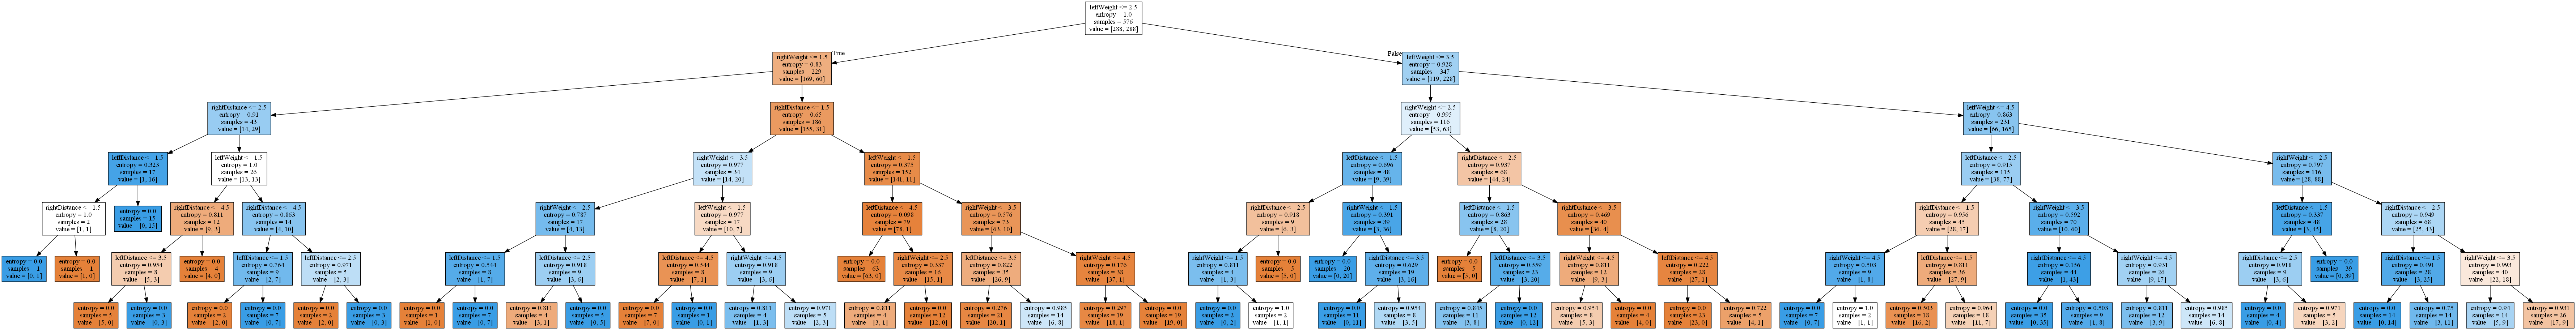

In [153]:
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=6,
)
decision_tree.fit(X, y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
#     class_names=['Not Returning', 'Returning'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [154]:
print(time.asctime())

Sat Jun  2 08:10:21 2018


In [155]:
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
accuracy_score(y_test, y_pred)

0.8055555555555556

I ran several combinations

|features|depth|score|
|----------|-------|-------|
|1|4|74.31%|
|1|5|84.03%|
|1|6|85.41%|
|2|4|79.86%|
|2|5|81.94%|
|2|6|84.72%|
|3|4|80.56%|
|3|5|84.72%|
|3|6|84.03%|
|4|4|83.33%|
|4|5|82.64%|
|4|6|84.72%|

They all ran pretty well. And running the seemingly best combination (1 feature, 6 deep) yielded results that varied betwen 82-85%. But this has me wondering what I'm trying to beat in terms of accuracy. Let's create a base rate with all 0's for our target. I expect it'll be very cose to 50%. But best to check. 

In [156]:
def base_rate_model(X):
    y = np.zeros(X.shape[0])
    return y

In [157]:
y_base_rate = base_rate_model(X_test)
print(accuracy_score(y_test, y_base_rate))

0.4930555555555556


As expected, we are trying to beat a 50/50 return. And are doing so quite well at 84%. But let's see what the random forest can do.

In [158]:
print(time.asctime())

Sat Jun  2 08:10:21 2018


In [159]:
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X, y, cv=10)

array([0.55172414, 0.75862069, 0.68965517, 0.87931034, 0.87931034,
       0.77586207, 0.89655172, 0.75862069, 0.94642857, 0.53571429])

In [160]:
print(time.asctime())

Sat Jun  2 08:10:21 2018


Look at that shameful variance. Some of them are in the 50s! Even though the assignment asks for a simple random forest and then to stop, I have to play with this a bit. 

In [161]:
rfc = ensemble.RandomForestClassifier(n_estimators=3)
cross_val_score(rfc, X, y, cv=10)

array([0.55172414, 0.74137931, 0.75862069, 0.93103448, 0.81034483,
       0.75862069, 0.86206897, 0.77586207, 0.82142857, 0.625     ])

Very interesting. I ran the random forest with a differing number of estimators from 2 to 25. And every time I increased the number of trees in the forest the accuracy decreased. This seems to be the opposite of the result I would expect as the text teaches that the use of many trees makes the forest very accurate and low in variance. I'll have to review this further to find an answer. 